In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.dates import DateFormatter

In [108]:
df = pd.read_csv('BRTimeHistory_1699221717_Europe_London.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Date'] = df['Timestamp'].dt.date
df['Time'] = df['Timestamp'].dt.time
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second
df['Time int'] = df['Timestamp'].dt.hour + df['Timestamp'].dt.minute / 60 + df['Timestamp'].dt.second / 3600
# df.drop('Region', axis=1, inplace=True)
df.drop('Moment ID', axis=1, inplace=True)
# df.drop('Time.dt.hour + europe['Timestamp'].dt.minute / 60stamp', axis=1, inplace=True)

In [109]:
grouped = df.groupby('Region')
dataframes = [group for _, group in grouped]
east_asia, west_asia, europe, america = dataframes

In [110]:
europe

,Region,Timestamp,Date,Time,Hour,Minute,Second,Time int
2,europe-west,2023-11-05 09:57:35,2023-11-05,09:57:35,9,57,35,9.959722
6,europe-west,2023-11-04 12:50:08,2023-11-04,12:50:08,12,50,8,12.835556
9,europe-west,2023-11-03 12:08:43,2023-11-03,12:08:43,12,8,43,12.145278
13,europe-west,2023-11-02 12:34:41,2023-11-02,12:34:41,12,34,41,12.578056
17,europe-west,2023-11-01 09:59:03,2023-11-01,09:59:03,9,59,3,9.984167
...,...,...,...,...,...,...,...,...
341,europe-west,2023-08-12 22:03:53,2023-08-12,22:03:53,22,3,53,22.064722
345,europe-west,2023-08-11 10:44:06,2023-08-11,10:44:06,10,44,6,10.735000
349,europe-west,2023-08-10 16:36:31,2023-08-10,16:36:31,16,36,31,16.608611
353,europe-west,2023-08-09 11:03:04,2023-08-09,11:03:04,11,3,4,11.051111


In [111]:
europe[['Hour', 'Minute', 'Second']].describe()

,Hour,Minute,Second
count,90.000000,90.000000,90.000000
mean,13.633333,28.366667,27.955556
std,3.648765,17.371325,18.012425
min,5.000000,1.000000,1.000000
25%,11.000000,13.000000,10.250000
50%,13.500000,27.000000,26.000000
75%,16.750000,43.000000,43.750000
max,22.000000,59.000000,59.000000


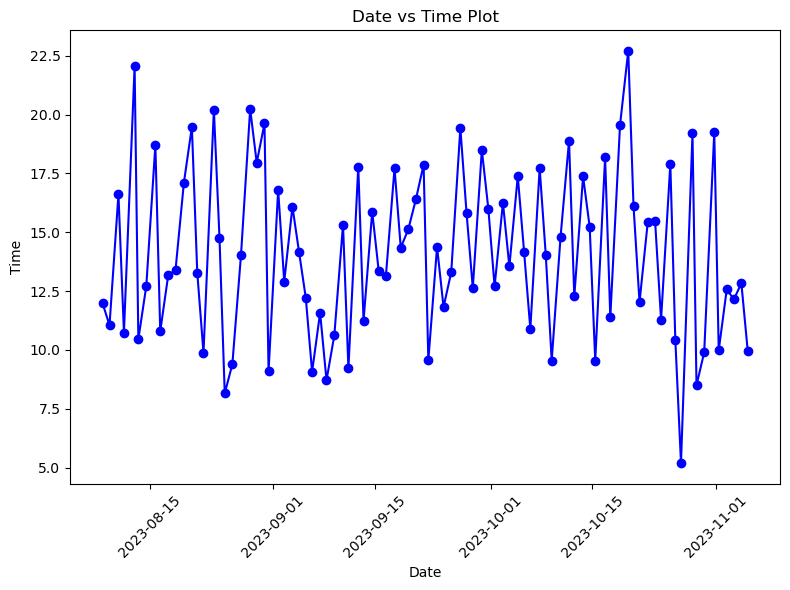

In [112]:
plt.figure(figsize=(8, 6))
plt.plot(europe['Timestamp'], europe['Time int'], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Time')
plt.title('Date vs Time Plot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

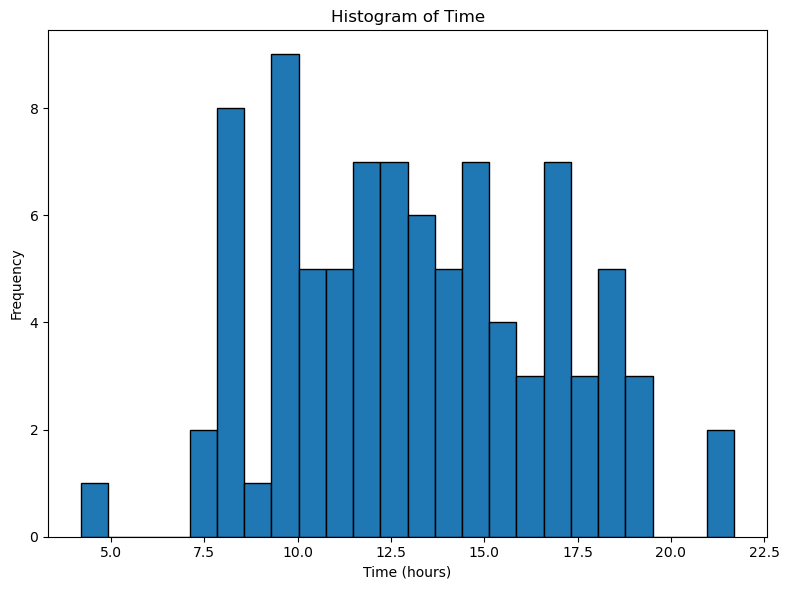

In [80]:
time_in_hours = europe['Timestamp'].dt.hour + europe['Timestamp'].dt.minute / 60 + europe['Timestamp'].dt.second / 3600
plt.figure(figsize=(8, 6))
plt.hist(time_in_hours, bins=24, edgecolor='black') 
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Time')
plt.tight_layout()
plt.show()

/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Timestamp', ylabel='Density'>

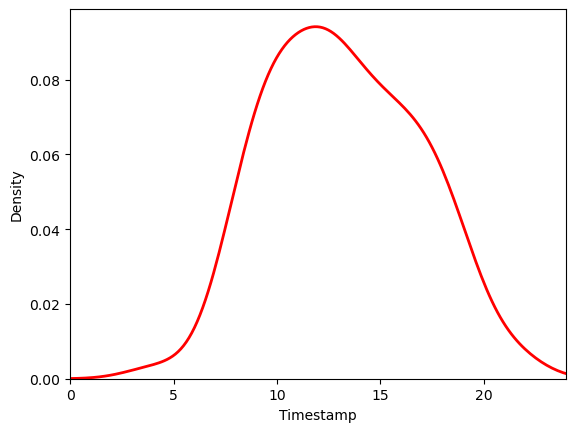

In [81]:
# sns.histplot(time_in_hours, color='b', bins=24, edgecolor='black')
plt.xlim(0, 24)
sns.kdeplot(time_in_hours, color='r', linewidth=2)